In [ ]:
# This reads in some scraped data and produces final data to plot,
# as a check on the class findHK()

# This should be used in conjunction with test_scrape_ew_and_errew.py

# Created 2019 Apr 13 by E.S.

In [48]:
import numpy as np
import pandas as pd
import configparser
import matplotlib.pyplot as plt

In [17]:
# configuration data
config = configparser.ConfigParser() # for parsing values in .init file
config.read("../rrlyrae_metallicity/modules2/config.ini")

['../rrlyrae_metallicity/modules2/config.ini']

In [9]:
stem = ("/Users/nyumbani/Documents/git.repos/rrlyrae_metallicity/"+\
    "rrlyrae_metallicity/tests/test_robospect_output")

In [19]:
# fake EW data (note this is with the fake 'bad' data removed)

scraped_EW_filename = config["data_dirs"]["TEST_DIR_ROBO_OUTPUT"] + config["file_names"]["MCD_LARGE_BAD_REMOVED"]

In [22]:
data = pd.read_csv(scraped_EW_filename)

In [27]:
# get the unique, 'good' spectrum names 

unique_good_empir_spec_names = data["empir_spec_name"].drop_duplicates().dropna().reset_index(drop=True) 

In [28]:
# print

unique_good_empir_spec_names

0           all_good_01
1           all_good_02
2    bad_hbeta_wavel_99
3    fit_center_flag_99
Name: empir_spec_name, dtype: object

In [39]:
# separate the data by absorption line

data_Heps = data.where(data["line_name"] == "Heps").dropna().reset_index(drop=True) 
data_Hdel = data.where(data["line_name"] == "Hdel").dropna().reset_index(drop=True) 
data_Hgam = data.where(data["line_name"] == "Hgam").dropna().reset_index(drop=True) 
data_Hbet = data.where(data["line_name"] == "Hbet").dropna().reset_index(drop=True) 
data_CaIIK = data.where(data["line_name"] == "CaIIK").dropna().reset_index(drop=True) 

In [44]:
data_Hbet

,Unnamed: 0,#x0,mean,sigma,flux,eta,dmean,dsigma,dflux,deta,...,FWHM_F,EQW,dEQW,chi,flags,group,file_name,synth_spec_name,empir_spec_name,line_name
0,4.0,4861.29,4860.6407,8.2356,-9.1300,0.0,0.2747,0.2057,0.0557,0.0,...,-6.7977,9130.0,55.670,1.3209,0x100000,0.0,all_good_01_004.fits.robolines,all_good_01_004,all_good_01,Hbet
1,9.0,4861.29,4861.7801,5.6602,-7.3202,0.0,0.0237,0.0180,0.0058,0.0,...,-5.8720,7320.0,5.781,0.7822,0x100000,0.0,all_good_01_066.fits.robolines,all_good_01_066,all_good_01,Hbet
2,14.0,4861.29,4857.5245,6.1681,-4.8622,0.0,0.2689,0.2054,0.0389,0.0,...,-2.2794,4862.0,38.880,1.5551,0x100000,0.0,all_good_01_102.fits.robolines,all_good_01_102,all_good_01,Hbet
3,19.0,4861.29,4860.2416,4.4429,-3.5125,0.0,0.0569,0.0404,0.0083,0.0,...,-2.7795,3513.0,8.312,1.6961,0x100000,0.0,all_good_01_107.fits.robolines,all_good_01_107,all_good_01,Hbet
4,24.0,4861.29,4861.3645,2.6207,-3.0776,0.0,0.0986,0.0737,0.0250,0.0,...,-2.4806,3078.0,24.950,1.3925,0x100000,0.0,all_good_02_004.fits.robolines,all_good_02_004,all_good_02,Hbet
5,29.0,4861.29,4861.9253,6.3915,-5.4727,0.0,0.2165,0.1600,0.0339,0.0,...,-3.5731,5473.0,33.930,1.5161,0x100000,0.0,all_good_02_014.fits.robolines,all_good_02_014,all_good_02,Hbet
6,34.0,4861.29,4861.4469,7.4885,-8.5589,0.0,0.1894,0.1422,0.0397,0.0,...,-6.8451,8559.0,39.740,1.4080,0x100000,0.0,all_good_02_044.fits.robolines,all_good_02_044,all_good_02,Hbet
7,39.0,4861.29,4862.1025,3.4133,-3.3565,0.0,0.0285,0.0214,0.0054,0.0,...,-2.5896,3357.0,5.365,1.0335,0x100000,0.0,all_good_02_058.fits.robolines,all_good_02_058,all_good_02,Hbet
8,44.0,4861.29,4866.1504,12.9699,-8.6292,0.0,1.1737,0.8760,0.1433,0.0,...,-4.1610,8629.0,143.300,1.1328,0x100000,0.0,all_good_02_104.fits.robolines,all_good_02_104,all_good_02,Hbet
9,49.0,4861.29,4893.1981,4.4166,-3.6246,0.0,0.0595,0.0447,0.0093,0.0,...,-2.8493,3625.0,9.262,0.9182,0x100000,0.0,bad_hbeta_wavel_99_999.fits.robolines,bad_hbeta_wavel_99_999,bad_hbeta_wavel_99,Hbet


In [45]:
# fit line to Hgamma (y) vs Hdelta (x)

m, b = np.polyfit(data_Hdel["EQW"], data_Hgam["EQW"], 1)

In [66]:
# make rescaled Hgamma: Hgamma’ = (Hgamma - b)/m

rHgam_ew = np.divide(np.subtract(data_Hgam["EQW"],b),m)

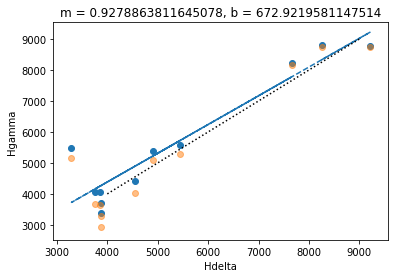

In [71]:
# plot Hgamma vs Hdelta before and after rescaling

plt.scatter(data_Hdel["EQW"], data_Hgam["EQW"])
plt.scatter(data_Hdel["EQW"], rHgam_ew, marker="o", alpha=0.5)
plt.plot(data_Hdel["EQW"],np.add(np.multiply(m,data_Hdel["EQW"]),b), linestyle="--")
plt.plot([4000,9000], [4000,9000], linestyle=":", color="k") # 1-to-1
plt.xlabel("Hdelta")
plt.ylabel("Hgamma")
plt.title("m = " + str(m) + ", b = " + str(b))
plt.show()

KeyError: -1